In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu")

print(f"DEVICE = \"{DEVICE}\"")

DEVICE = "cuda"


## Préparation des données

In [21]:
def apply_random_mask(img, mask_size_range=(4, 12)):
    """
    Applique un masque carré aléatoire sur l'image.
    Retourne: l'image masquée et le masque lui-même.
    """
    c, h, w = img.shape
    mask = torch.zeros((1, h, w))

    size = torch.randint(mask_size_range[0], mask_size_range[1], (1,)).item()

    x_pos = torch.randint(0, h - size, (1,)).item()
    y_pos = torch.randint(0, w - size, (1,)).item()
    
    # Masquage de l'image d'origine
    mask[:, x_pos:x_pos+size, y_pos:y_pos+size] = 1.0
    masked_img = img.clone()
    masked_img = masked_img * (1 - mask)
    
    return masked_img, mask

In [22]:
class InpaintingDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        # On génère un masque différent à chaque époque pour la data augmentation
        masked_img, mask = apply_random_mask(img)
        return img, masked_img, mask, label

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # Normalisation entre -1 et 1
])

mnist = datasets.MNIST(root='../data', train=True, download=True, transform=transform)

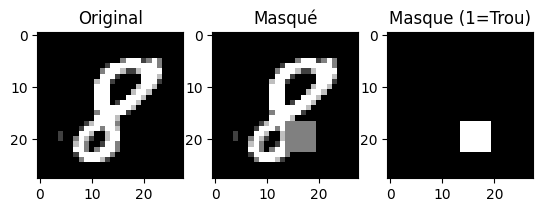

In [24]:
BATCH_SIZE = 64

dataset = InpaintingDataset(mnist)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

img, masked, mask, _ = next(iter(dataloader))
fig, axs = plt.subplots(1, 3)
axs[0].imshow(img[0].squeeze(), cmap='gray'); axs[0].set_title("Original")
axs[1].imshow(masked[0].squeeze(), cmap='gray'); axs[1].set_title("Masqué")
axs[2].imshow(mask[0].squeeze(), cmap='gray'); axs[2].set_title("Masque (1=Trou)")
plt.show()

## Création de notre modèle

In [25]:
class TimeEmbedding(nn.Module):
    def __init__(self, n_channels):
        super().__init__()
        self.n_channels = n_channels
        self.lin1 = nn.Linear(self.n_channels // 4, self.n_channels)
        self.act = nn.SiLU()
        self.lin2 = nn.Linear(self.n_channels, self.n_channels)

    def forward(self, t):
        half_dim = self.n_channels // 8
        emb = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=1)
        
        emb = self.act(self.lin1(emb))
        emb = self.lin2(emb)
        return emb

class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.act = nn.SiLU()

    def forward(self, x, t):
        h = self.bnorm1(self.act(self.conv1(x)))
        time_emb = self.act(self.time_mlp(t))

        h += time_emb[(..., ) + (None, ) * 2]
        h = self.bnorm2(self.act(self.conv2(h)))
        return self.transform(h)

class SimpleUNet(nn.Module):
    def __init__(self):
        super().__init__()
        image_channels = 1
        down_channels = (64, 128, 256)
        up_channels = (256, 128, 64)
        out_dim = 1 
        time_emb_dim = 32

        self.time_mlp = TimeEmbedding(time_emb_dim)

        # 3 canaux: image bruitée + image masquée + masque
        self.input_channels = 3 
        self.conv0 = nn.Conv2d(self.input_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], time_emb_dim) \
                                    for i in range(len(down_channels)-1)])
        
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], time_emb_dim, up=True) \
                                  for i in range(len(up_channels)-1)])
        
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, t, masked_img, mask):
        t = self.time_mlp(t)
        x = torch.cat((x, masked_img, mask), dim=1)

        x = self.conv0(x)
        residuals = []

        for down in self.downs:
            x = down(x, t)
            residuals.append(x)

        for up in self.ups:
            residual = residuals.pop()
            x = torch.cat((x, residual), dim=1)
            x = up(x, t)

        return self.output(x)

In [26]:
LR = 1e-4

model = SimpleUNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [27]:
T = 1000

beta = torch.linspace(1e-4, 0.02, T).to(DEVICE)
alpha = 1. - beta
alpha_hat = torch.cumprod(alpha, dim=0)

def forward_diffusion(x0, t):
    """
    Bruite l'image x0 au temps t.
    Retourne l'image bruitée et le bruit ajouté.
    """
    sqrt_alpha_hat = torch.sqrt(alpha_hat[t])[:, None, None, None]
    sqrt_one_minus_alpha_hat = torch.sqrt(1 - alpha_hat[t])[:, None, None, None]
    
    epsilon = torch.randn_like(x0)
    return sqrt_alpha_hat * x0 + sqrt_one_minus_alpha_hat * epsilon, epsilon

## Entrainement du modèle

In [28]:
PROB_UNCOND = 0.1
EPOCHS = 50
IMG_SIZE = 28
CHANNELS = 1

def train():
    model.train()
    loss_history = []
    
    for epoch in range(EPOCHS):
        pbar = tqdm(dataloader)
        for x0, masked_img, mask, _ in pbar:
            x0 = x0.to(DEVICE)
            masked_img = masked_img.to(DEVICE)
            mask = mask.to(DEVICE)

            # Echantillonner t uniformément
            t = torch.randint(0, T, (x0.shape[0],), device=DEVICE).long()

            # Création l'image bruitée x_t
            x_t, noise = forward_diffusion(x0, t)

            # Dropout de Condition (CFG)
            if np.random.random() < PROB_UNCOND:
                masked_img = torch.zeros_like(masked_img)
                mask = torch.zeros_like(mask)

            # Prédiction du bruit
            noise_pred = model(x_t, t, masked_img, mask)

            loss = F.mse_loss(noise_pred, noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            pbar.set_description(f"Epoch {epoch+1:3} | Loss: {loss.item():.4f}")
            loss_history.append(loss.item())

    plt.plot(loss_history)
    plt.title("Training curve")
    plt.show()

Epoch   1 | Loss: 0.0553: 100%|██████████| 938/938 [01:25<00:00, 10.91it/s]
Epoch   2 | Loss: 0.0245: 100%|██████████| 938/938 [01:24<00:00, 11.08it/s]
Epoch   3 | Loss: 0.0115: 100%|██████████| 938/938 [01:23<00:00, 11.17it/s]
Epoch   4 | Loss: 0.0105: 100%|██████████| 938/938 [01:24<00:00, 11.16it/s]
Epoch   5 | Loss: 0.0428: 100%|██████████| 938/938 [01:24<00:00, 11.15it/s]
Epoch   6 | Loss: 0.0598: 100%|██████████| 938/938 [01:23<00:00, 11.19it/s]
Epoch   7 | Loss: 0.0090: 100%|██████████| 938/938 [01:24<00:00, 11.12it/s]
Epoch   8 | Loss: 0.0063: 100%|██████████| 938/938 [01:24<00:00, 11.13it/s]
Epoch   9 | Loss: 0.0065: 100%|██████████| 938/938 [01:24<00:00, 11.09it/s]
Epoch  10 | Loss: 0.0107: 100%|██████████| 938/938 [01:24<00:00, 11.09it/s]
Epoch  11 | Loss: 0.0333: 100%|██████████| 938/938 [01:24<00:00, 11.12it/s]
Epoch  12 | Loss: 0.0063: 100%|██████████| 938/938 [01:24<00:00, 11.09it/s]
Epoch  13 | Loss: 0.0183: 100%|██████████| 938/938 [01:24<00:00, 11.08it/s]
Epoch  14 | 

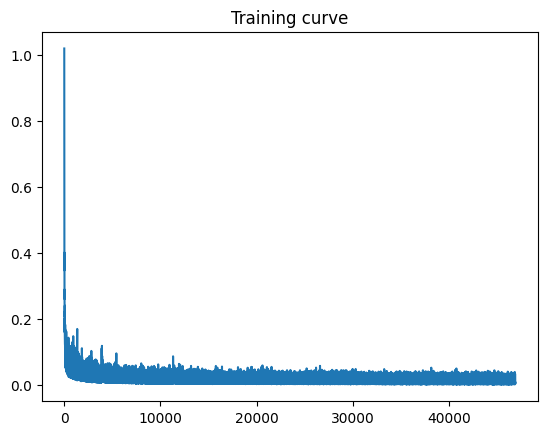

In [29]:
train()

## Génération de la partie masquée (Inpainting)

In [30]:
@torch.no_grad()
def sample_cfg(model, masked_img, mask, w=3.0, inpainting=False):
    """
    Génère la partie manquante avec guidance w.
    masked_img: Image avec trou (Batch, 1, 28, 28)
    mask: Le masque (Batch, 1, 28, 28)
    w: Guidance scale (CFG weight)
    """
    model.eval()
    n = masked_img.shape[0]
    
    # On commence avec du bruit pur
    x = torch.randn((n, 1, IMG_SIZE, IMG_SIZE)).to(DEVICE)
    
    # Conditions vides pour la part inconditionnelle
    null_masked = torch.zeros_like(masked_img).to(DEVICE)
    null_mask = torch.zeros_like(mask).to(DEVICE)
    
    # Boucle inverse : T -> 0
    for i in tqdm(reversed(range(1, T)), desc="Sampling", total=T-1):
        t = (torch.ones(n) * i).long().to(DEVICE)

        # Prédiction Conditionnelle et Incondtionnelle
        eps_cond = model(x, t, masked_img, mask)
        eps_uncond = model(x, t, null_masked, null_mask)

        # CFG
        eps = eps_uncond + w * (eps_cond - eps_uncond)

        # DDPM
        alpha_t = alpha[t][:, None, None, None]
        alpha_hat_t = alpha_hat[t][:, None, None, None]
        beta_t = beta[t][:, None, None, None]

        if i > 1:
            z = torch.randn_like(x)
        else:
            z = torch.zeros_like(x)

        x = (1 / torch.sqrt(alpha_t)) * (x - ((1 - alpha_t) / (torch.sqrt(1 - alpha_hat_t))) * eps) + torch.sqrt(beta_t) * z

        # Inpainting (si set à True)
        original_noisy, _ = forward_diffusion(masked_img, t-1) if i > 1 else (masked_img, None)
        if inpainting: 
            x = x * mask + original_noisy * (1 - mask)

    return x

### Génération sans inpainting

Sampling: 100%|██████████| 999/999 [00:04<00:00, 210.57it/s]


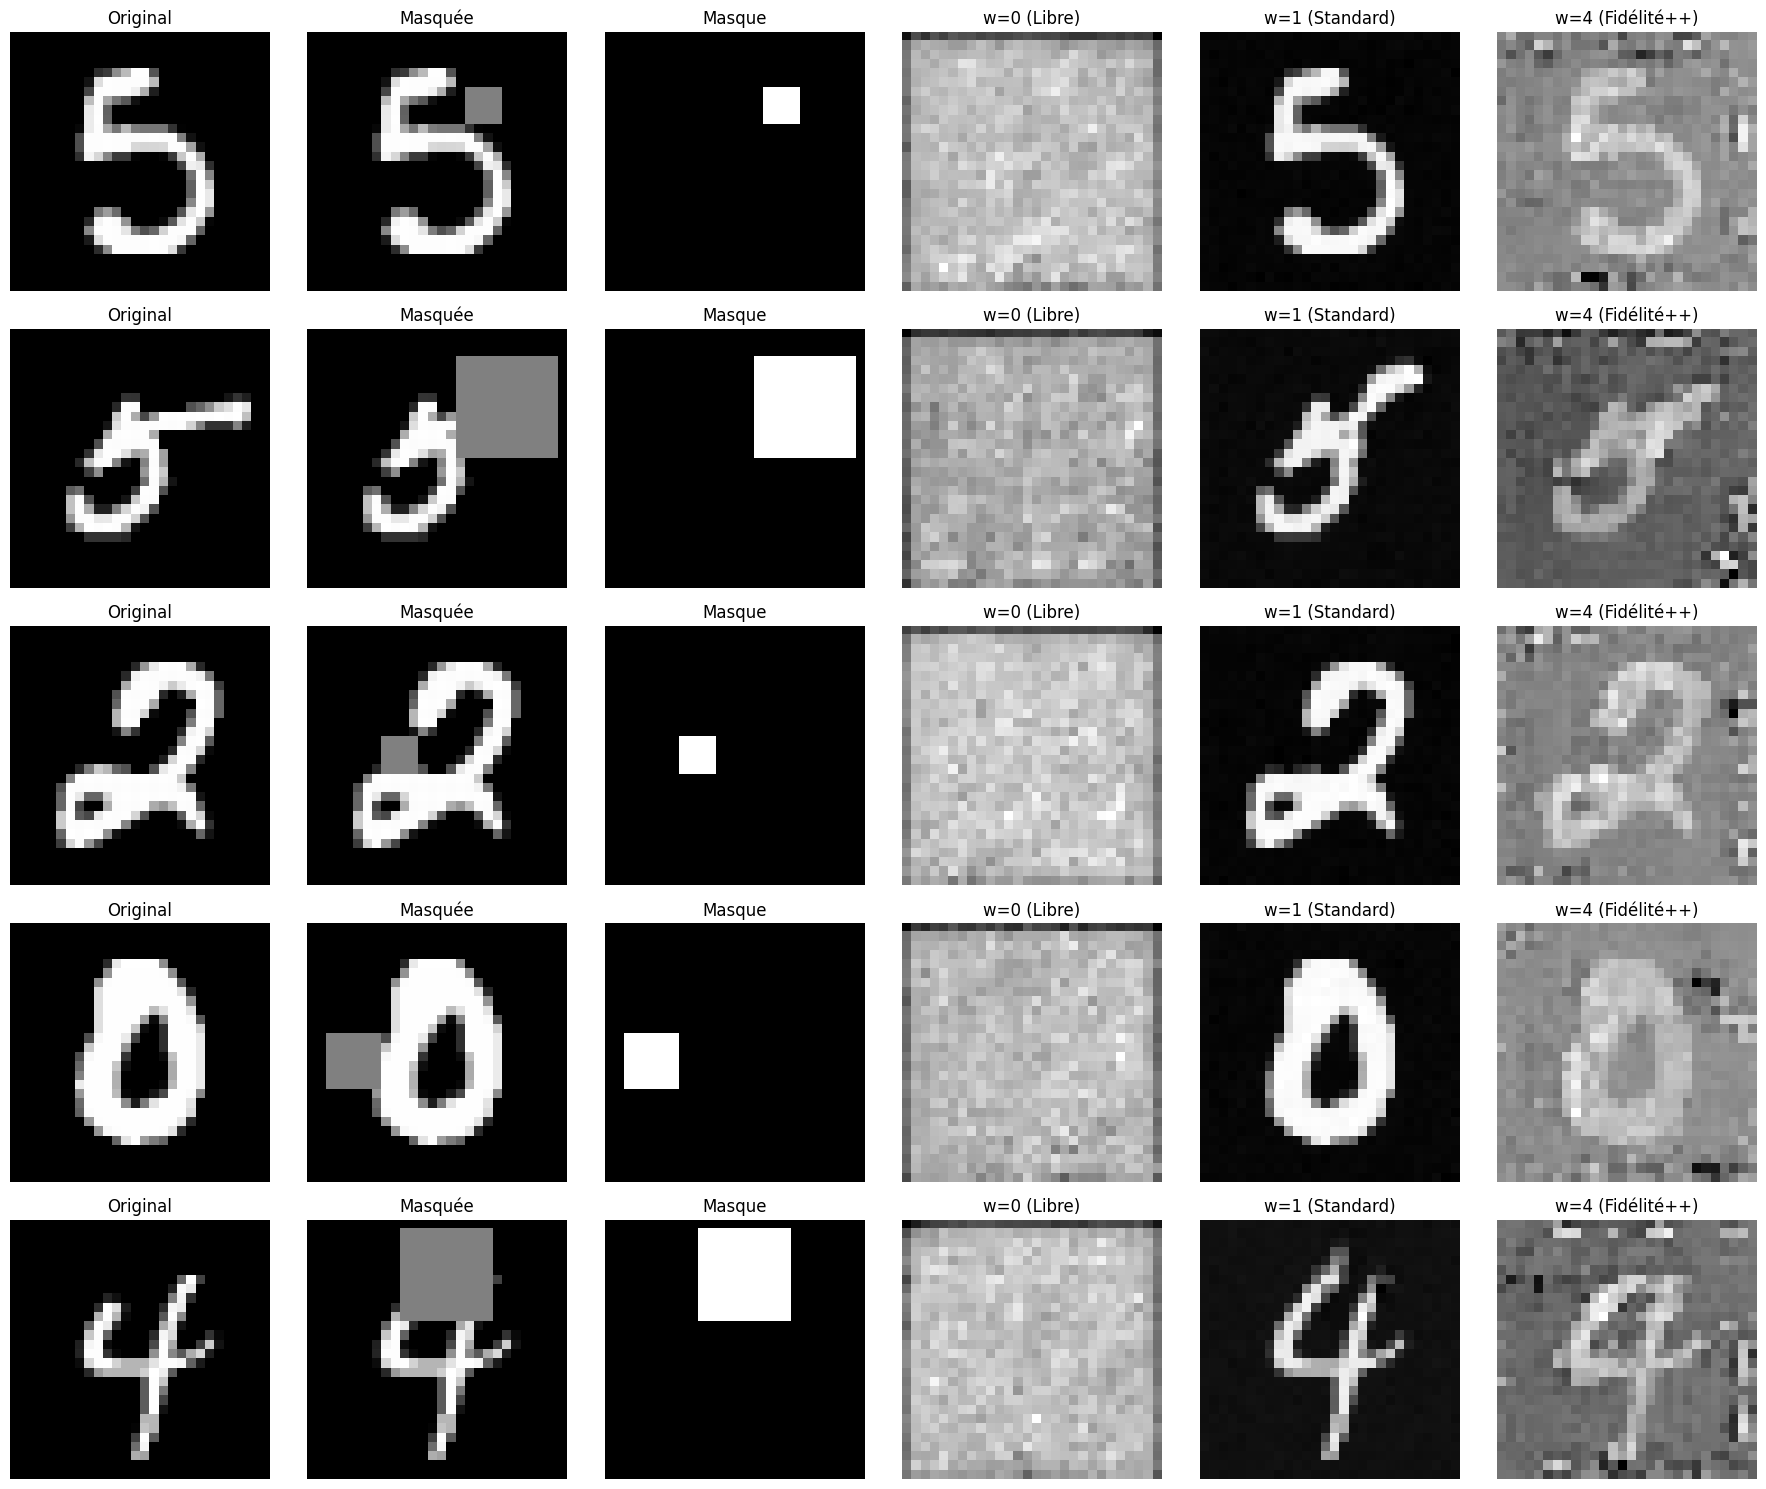

In [31]:
fig, axs = plt.subplots(5, 6, figsize=(18, 15))

for row in range(5):
    idx = np.random.randint(len(dataset))
    test_img, test_masked, test_mask, _ = dataset[idx]
    test_img_display = test_img.clone()
    test_masked = test_masked.unsqueeze(0).to(DEVICE)
    test_mask = test_mask.unsqueeze(0).to(DEVICE)

    res_w0 = sample_cfg(model, test_masked, test_mask, w=0.0)
    res_w1 = sample_cfg(model, test_masked, test_mask, w=1.0)
    res_w4 = sample_cfg(model, test_masked, test_mask, w=4.0)

    axs[row, 0].imshow(test_img_display.squeeze(), cmap='gray'); axs[row, 0].set_title("Original")
    axs[row, 1].imshow(test_masked.cpu().squeeze(), cmap='gray'); axs[row, 1].set_title("Masquée")
    axs[row, 2].imshow(test_mask.cpu().squeeze(), cmap='gray'); axs[row, 2].set_title("Masque")
    axs[row, 3].imshow(res_w0.cpu().squeeze(), cmap='gray'); axs[row, 3].set_title("w=0 (Libre)")
    axs[row, 4].imshow(res_w1.cpu().squeeze(), cmap='gray'); axs[row, 4].set_title("w=1 (Standard)")
    axs[row, 5].imshow(res_w4.cpu().squeeze(), cmap='gray'); axs[row, 5].set_title("w=4 (Fidélité++)")

for ax in axs.flat:
    ax.axis('off')

plt.tight_layout()
plt.show()

### Génération avec inpainting

Sampling: 100%|██████████| 999/999 [00:04<00:00, 218.39it/s]


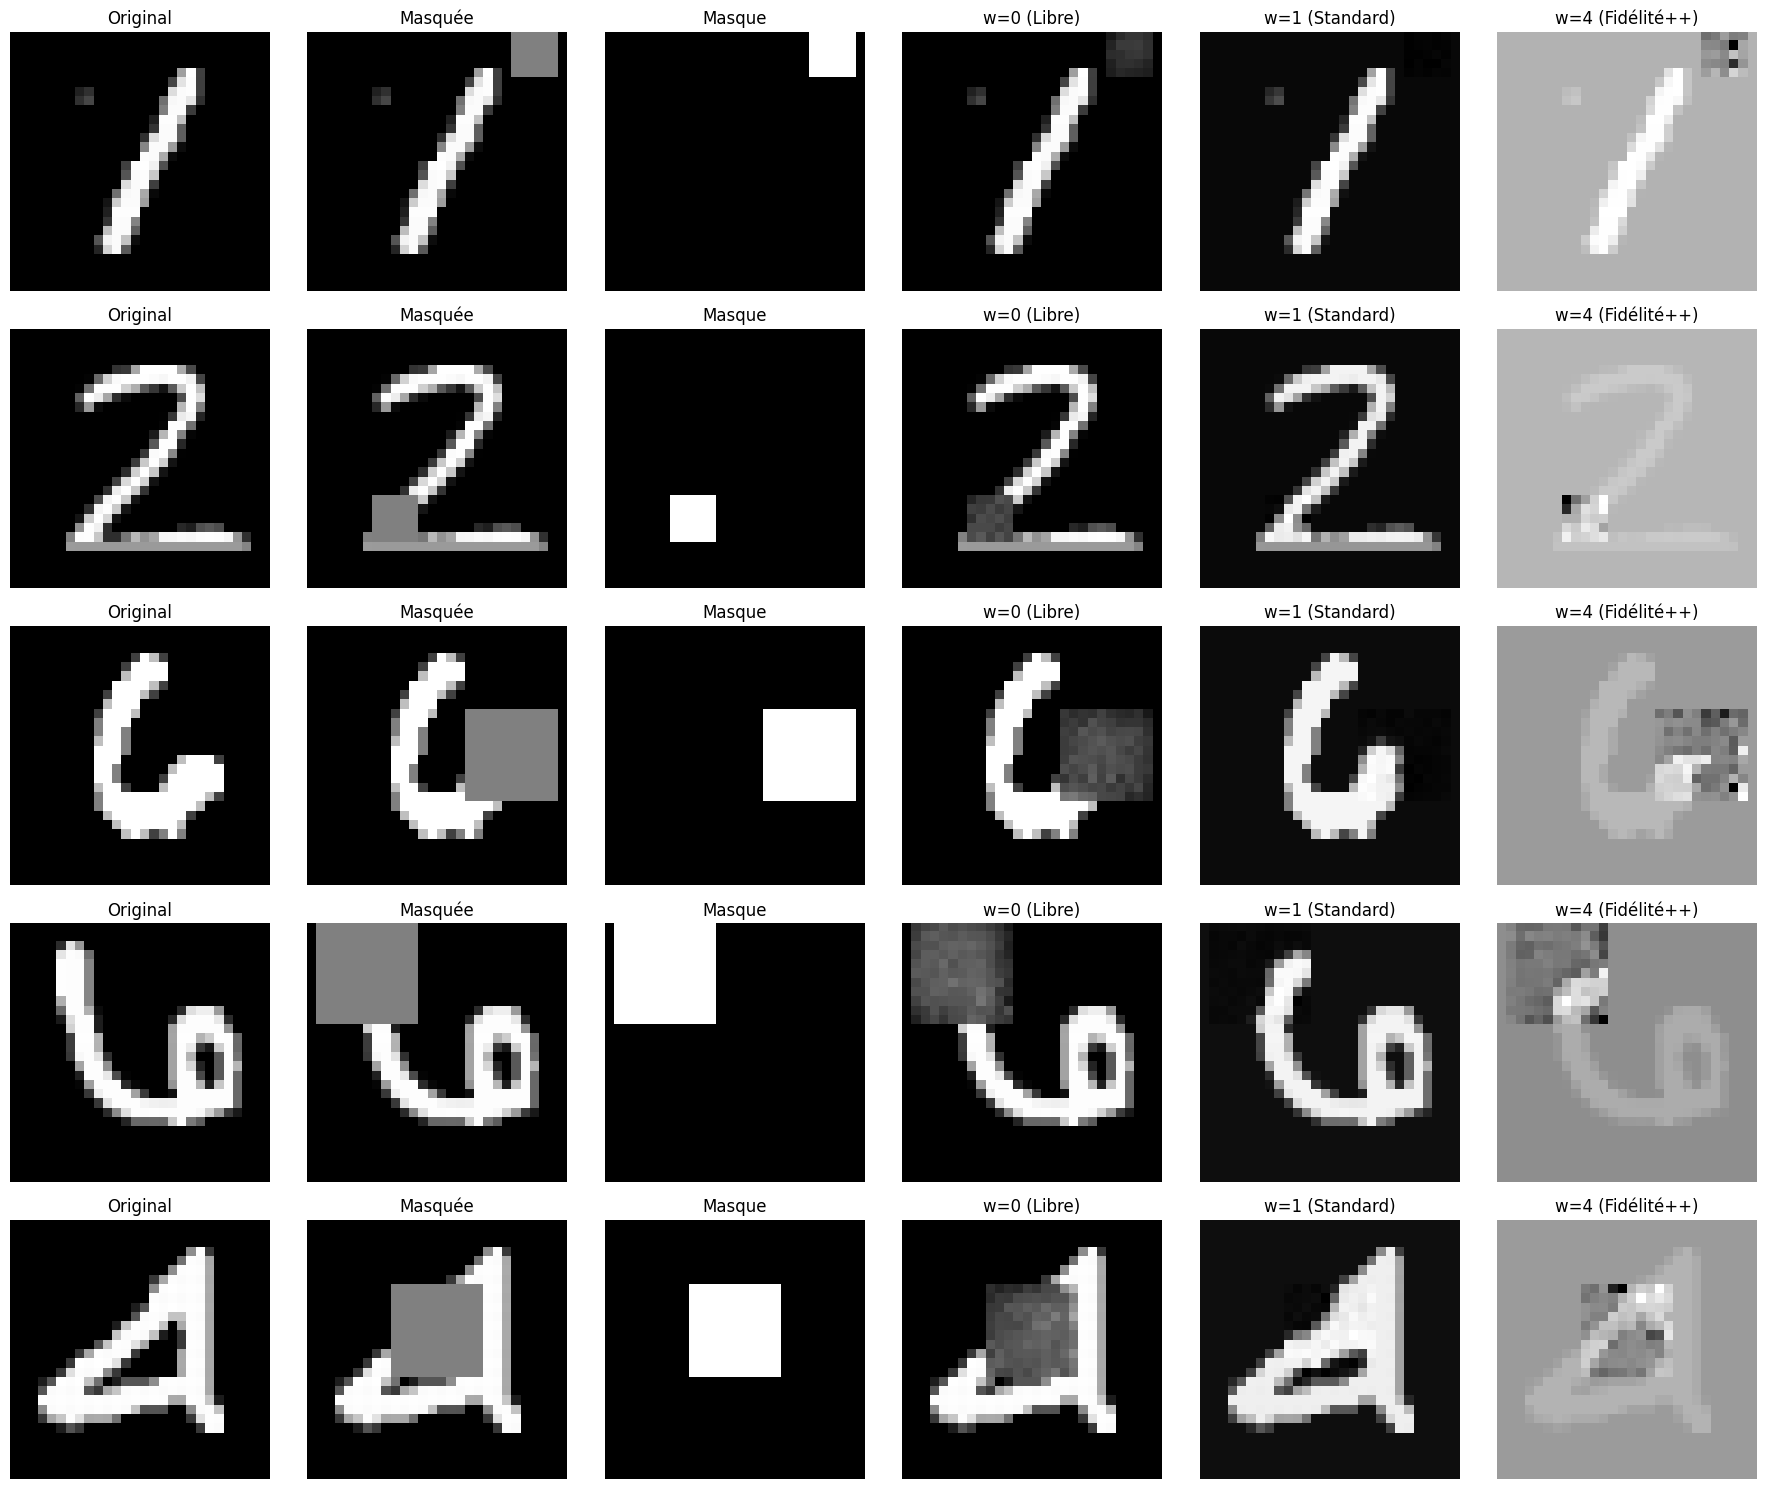

In [32]:
fig, axs = plt.subplots(5, 6, figsize=(18, 15))

for row in range(5):
    idx = np.random.randint(len(dataset))
    test_img, test_masked, test_mask, _ = dataset[idx]
    test_img_display = test_img.clone()
    test_masked = test_masked.unsqueeze(0).to(DEVICE)
    test_mask = test_mask.unsqueeze(0).to(DEVICE)

    res_w0 = sample_cfg(model, test_masked, test_mask, w=0.0, inpainting=True)
    res_w1 = sample_cfg(model, test_masked, test_mask, w=1.0, inpainting=True)
    res_w4 = sample_cfg(model, test_masked, test_mask, w=4.0, inpainting=True)

    axs[row, 0].imshow(test_img_display.squeeze(), cmap='gray'); axs[row, 0].set_title("Original")
    axs[row, 1].imshow(test_masked.cpu().squeeze(), cmap='gray'); axs[row, 1].set_title("Masquée")
    axs[row, 2].imshow(test_mask.cpu().squeeze(), cmap='gray'); axs[row, 2].set_title("Masque")
    axs[row, 3].imshow(res_w0.cpu().squeeze(), cmap='gray'); axs[row, 3].set_title("w=0 (Libre)")
    axs[row, 4].imshow(res_w1.cpu().squeeze(), cmap='gray'); axs[row, 4].set_title("w=1 (Standard)")
    axs[row, 5].imshow(res_w4.cpu().squeeze(), cmap='gray'); axs[row, 5].set_title("w=4 (Fidélité++)")

for ax in axs.flat:
    ax.axis('off')

plt.tight_layout()
plt.show()

### Génération avec inpainting et MSE

In [33]:
def mse(original, generated, mask):
    """
    Calcule l'erreur quadratique moyenne (MSE) uniquement dans la zone masquée.
    """
    diff = (original - generated) ** 2
    mse_hole = (diff * mask).sum() / (mask.sum() + 1e-8)
    return mse_hole.item()

Sampling: 100%|██████████| 999/999 [00:04<00:00, 210.60it/s]


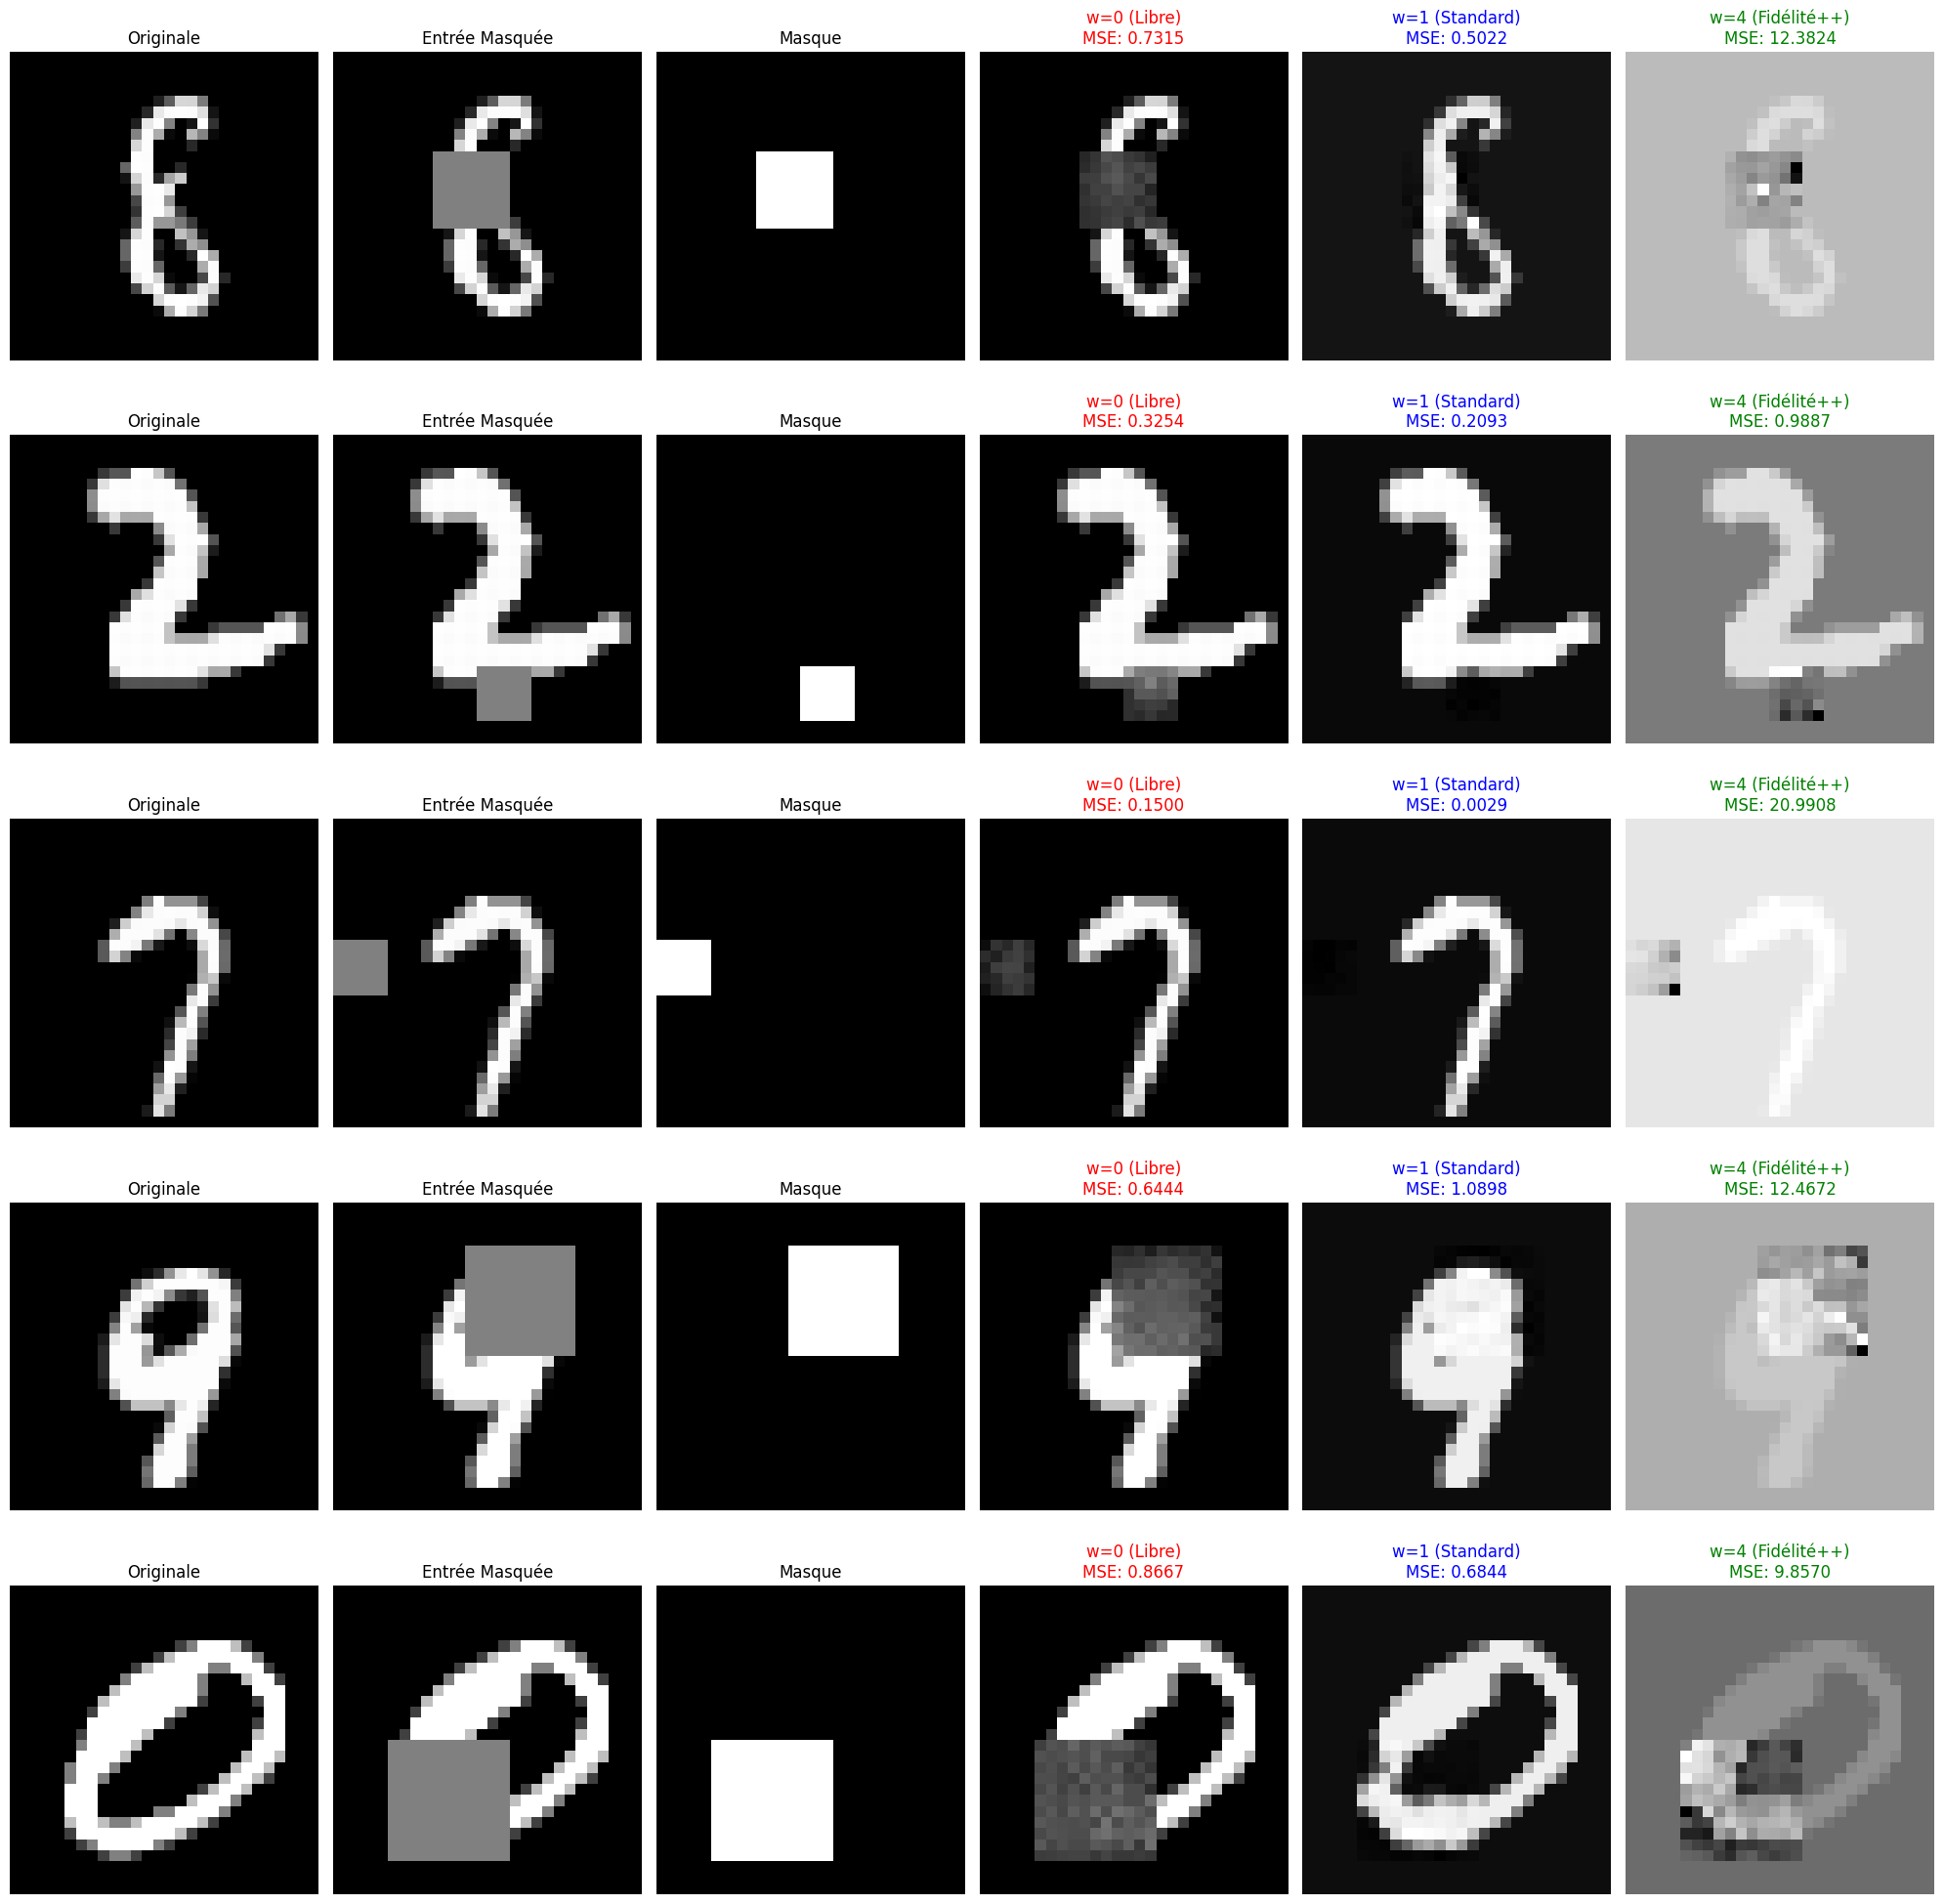

In [34]:
n_visu = 5
results_list = []

fig, axs = plt.subplots(n_visu, 6, figsize=(20, 4 * n_visu))

model.eval()
with torch.no_grad():
    for row in range(n_visu):
        idx = np.random.randint(len(dataset))
        original_img, masked_img, mask, _ = dataset[idx]

        original_gpu = original_img.unsqueeze(0).to(DEVICE)
        masked_gpu = masked_img.unsqueeze(0).to(DEVICE)
        mask_gpu = mask.unsqueeze(0).to(DEVICE)

        res_w0 = sample_cfg(model, masked_gpu, mask_gpu, w=0.0, inpainting=True)
        res_w1 = sample_cfg(model, masked_gpu, mask_gpu, w=1.0, inpainting=True)
        res_w4 = sample_cfg(model, masked_gpu, mask_gpu, w=4.0, inpainting=True)

        mse_0 = mse(original_gpu, res_w0, mask_gpu)
        mse_1 = mse(original_gpu, res_w1, mask_gpu)
        mse_4 = mse(original_gpu, res_w4, mask_gpu)

        results_list.append({
            "Image ID": idx,
            "MSE (w=0)": mse_0,
            "MSE (w=1)": mse_1,
            "MSE (w=4)": mse_4
        })

        axs[row, 0].imshow(original_img.squeeze(), cmap='gray')
        axs[row, 0].set_title("Originale")
        axs[row, 1].imshow(masked_img.squeeze(), cmap='gray')
        axs[row, 1].set_title("Entrée Masquée")
        axs[row, 2].imshow(mask.squeeze(), cmap='gray')
        axs[row, 2].set_title("Masque")
        axs[row, 3].imshow(res_w0.cpu().squeeze(), cmap='gray')
        axs[row, 3].set_title(f"w=0 (Libre)\nMSE: {mse_0:.4f}", color='red')
        axs[row, 4].imshow(res_w1.cpu().squeeze(), cmap='gray')
        axs[row, 4].set_title(f"w=1 (Standard)\nMSE: {mse_1:.4f}", color='blue')
        axs[row, 5].imshow(res_w4.cpu().squeeze(), cmap='gray')
        axs[row, 5].set_title(f"w=4 (Fidélité++)\nMSE: {mse_4:.4f}", color='green')

for ax in axs.flat:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [35]:
df_res = pd.DataFrame(results_list)
mean_row = pd.DataFrame([df_res.mean()], index=["mean"])
df = pd.concat([df_res, mean_row])

df

,Image ID,MSE (w=0),MSE (w=1),MSE (w=4)
0,46110.0,0.731492,0.502249,12.382381
1,19721.0,0.325414,0.209258,0.988702
2,51911.0,0.150036,0.002852,20.990845
3,49801.0,0.644440,1.089807,12.467185
4,54853.0,0.866682,0.684426,9.856997
mean,44479.2,0.543613,0.497718,11.337222
